# Data Visualization

Many types of visualizations have been developed to examine different kinds of relationships in datasets. We will review methods for plotting distributions, summarizing central tendency in different conditions, and plotting relationships.

## Preparing data for plotting

To plot data in a DataFrame, we will first need to load the data and do any necessary data cleaning and reorganization. We will prepare the Osth & Fox (2019) using methods that we have discussed before.

Let's load the Osth & Fox (2019) dataset, then clean it as we've done previously. This time, we'll use the `datascipsych.datasets.clean_osth` function to prepare the DataFrame. We'll also use `filter` to get just the trials from the test phase.

In [1]:
import polars as pl
from datascipsych import datasets
raw = pl.read_csv(datasets.get_dataset_file("Osth2019"))
data = datasets.clean_osth(raw).filter(pl.col("phase") == "test")
data.head()

subj,cycle,phase,trial,type,word1,word2,response,RT,correct,lag,probe_type
i64,i64,str,i64,str,str,str,i64,f64,i64,i64,str
101,0,"""test""",-1,"""rearranged""","""waste""","""degree""",0,2.312,1,2,"""lure"""
101,0,"""test""",0,"""rearranged""","""needed""","""able""",0,3.542,1,1,"""lure"""
101,0,"""test""",1,"""rearranged""","""single""","""clean""",0,2.084,1,3,"""lure"""
101,0,"""test""",2,"""rearranged""","""train""","""useful""",0,1.669,1,2,"""lure"""
101,0,"""test""",3,"""rearranged""","""knees""","""various""",0,2.326,1,5,"""lure"""


Next, we'll need to calculate the descriptive statistics that we want to plot. First, we'll calculate the hit rate and false-alarm rate for each subject.

In [2]:
perf = (
    data.group_by("subj", "probe_type")
    .agg(
        pl.col("response").mean(), 
        pl.col("RT").mean(),
    )
    .sort("subj", "probe_type")
)
perf.head()

subj,probe_type,response,RT
i64,str,f64,f64
101,"""lure""",0.108333,1.924008
101,"""target""",0.76569,1.646904
102,"""lure""",0.241667,1.088396
102,"""target""",0.2875,1.061537
103,"""lure""",0.091667,1.415992


Now that we have calculated our measures of interest, we are ready to create a plot to visualize responses in the lure and target conditions.

## Using Seaborn

In Seaborn, plots are usually created by passing a DataFrame to a function and specifying how the variables in the DataFrame should be used in the plot. There are three main types of plot:

Distribution
: plot the distribution of one or more variables using a histogram or density plot.

Categorical
: plot a distribution or central tendency for multiple variables side-by-side.

Relational
: plot the relationship between two or more variables.

Seaborn has tools for easily making all of these plot types, and also includes helpful features to change the appearance of figures.

To work with Seaborn, we must first import it. The Seaborn package is named after [Samuel Norman Seaborn](https://en.wikipedia.org/wiki/Sam_Seaborn), the fictional White House Communications Director on the TV show The West Wing. The conventional way to abbreviate Seaborn when importing it is using `sns`, after the initials of the package's namesake.

In [3]:
import seaborn as sns

Seaborn comes with different built-in styles. To illustrate them, let's use the example plot from Seaborn's [tutorial](https://seaborn.pydata.org/tutorial/aesthetics.html). It plots a series of different sine waves.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def sinplot(n=10, flip=1):
    x = np.linspace(0, 14, 100)
    for i in range(1, n + 1):
        plt.plot(x, np.sin(x + i * .5) * (n + 2 - i) * flip)

Seaborn comes with four styles, which make plots that include a grid, ticks, or neither. The `ticks` style is probably the most commonly used.

To visualize these styles, we use the `axes_style` function to set a different style for each of a series of subplots.

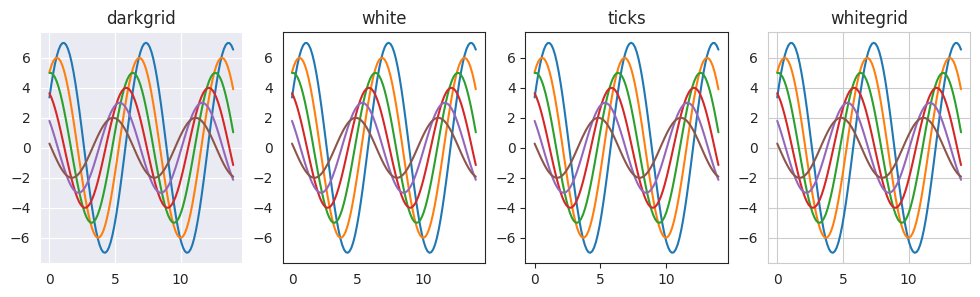

In [5]:
f = plt.figure(figsize=(12, 3))
styles = ["darkgrid", "white", "ticks", "whitegrid"]
gs = f.add_gridspec(1, len(styles))
for i, style in enumerate(styles):
    with sns.axes_style(style):
        ax = f.add_subplot(gs[i])
        sinplot(6)
        ax.set_title(style)


The easiest way to set the style, however, is to just run `set_style` once at the top of a notebook. That will set the style for all plots from that point on.

In [6]:
sns.set_style("ticks")

## Distribution plots

In Seaborn, there are multiple ways to visualize a distribution of observations. Before, we used `plt.hist` to make histograms. Seaborn lets us quickly make histograms from DataFrames more flexibly.

To make a distribution plot, we can use the `displot` function. The `kind` variable determines how the distribution is visualized.

histplot
: summarize data in bins using a histogram.

kdeplot
: summarize data with a kernel density estimation plot.

We can create a histogram by calling `displot` and setting the `kind` to `"hist"`. We'll first make a histogram of mean response time across subjects. We set `data` to the DataFrame with the data we want to plot, and `x` to the name of the column of `data` we want to plot. Note that we end the command with a semicolon (`;`); this suppresses printing of the Seaborn object produced by `sns.displot`.

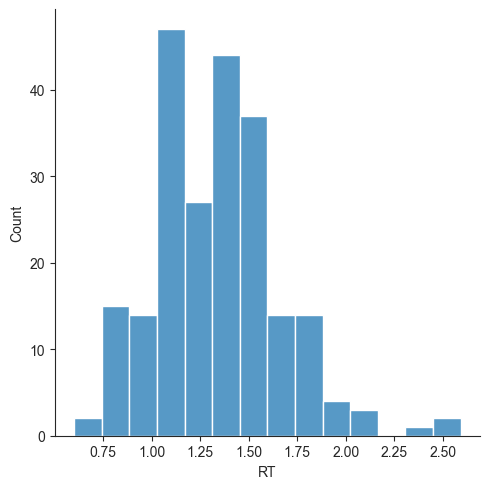

In [7]:
sns.displot(data=perf, x="RT", kind="hist");

Note that Seaborn does some work for us, getting the data from the DataFrame and making a histogram, and labeling the axes based on our data.

Sometimes, it's helpful to compare multiple distributions on the same plot. We can do this by setting the `hue` parameter, which splits up the data and plots each group with a different color.

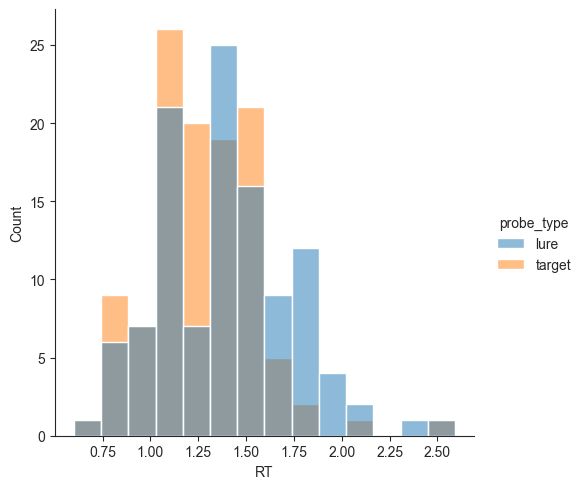

In [8]:
sns.displot(data=perf, x="RT", hue="probe_type", kind="hist");

Seaborn automatically determines good visualization properties for us, selecting two highly contrasting colors and plotting the overlap between the histograms using a different color. This makes it easy to see that response times for lure and target trials are similar, but target trial responses tend to be faster.

Histograms split the data into bins and count up the number of observations in each bin. Seaborn also supports kernel density estimation plots, which use a *kernel* instead of bins. This method smooths the underlying data to give an estimate of how dense observations are at each point.

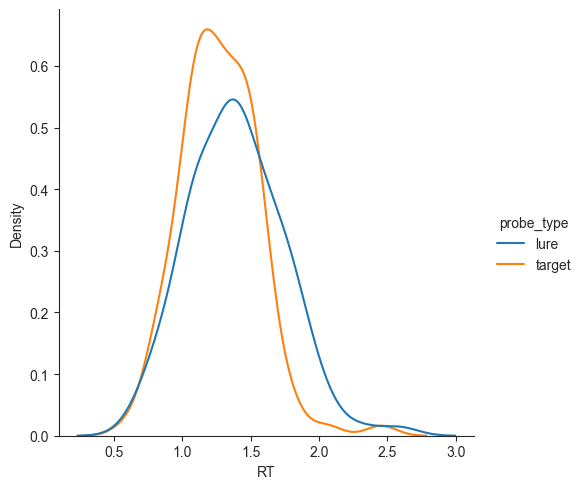

In [9]:
sns.displot(data=perf, x="RT", hue="probe_type", kind="kde");

This type of plot can sometimes make it easier to compare conditions. However, it is important to keep in mind that a KDE plot does not show the underlying data directly; instead, it estimates a smoothed version of the distribution and plots that.

We can save the figure to a file using the Seaborn object that is returned by its plotting functions. First, we assign the Seaborn FacetGrid object to a variable called `g`. Then, we use the `savefig` method to save out the file. The type of file is automatically determined by the file extension we provde. Here, we'll save to a PDF file. PDF files are often a good choice for plots, because they store a *vector* format that does not have a resolution. This means that we can zoom in as much as we want without seeing any pixels.

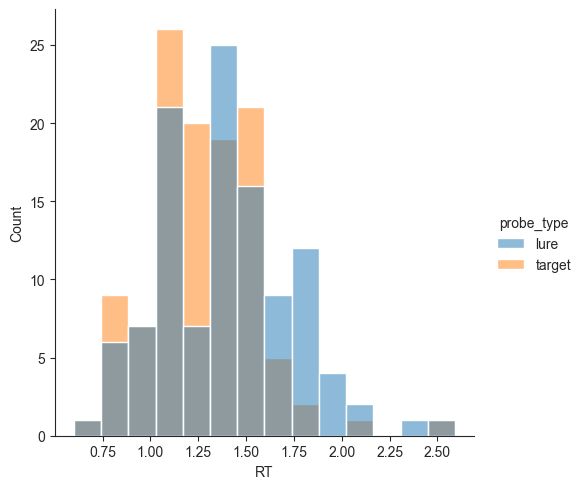

In [10]:
g = sns.displot(data=perf, x="RT", hue="probe_type", kind="hist")
# g.savefig("histogram.pdf")  # uncomment to save figure

See the Seaborn documentation for more information about [visualizing distributions](https://seaborn.pydata.org/tutorial/distributions.html).

### Exercise: distributional plots

Given the `data` DataFrame, which has all the responses from the test phase of Osth & Fox (2019), make a histogram showing the distributions of response time for lure and target trials. The lure and target trials should be shown in different hues in the plot.

Make a kernel density estimate (KDE) plot of the same data.

In [11]:
data.head()

subj,cycle,phase,trial,type,word1,word2,response,RT,correct,lag,probe_type
i64,i64,str,i64,str,str,str,i64,f64,i64,i64,str
101,0,"""test""",-1,"""rearranged""","""waste""","""degree""",0,2.312,1,2,"""lure"""
101,0,"""test""",0,"""rearranged""","""needed""","""able""",0,3.542,1,1,"""lure"""
101,0,"""test""",1,"""rearranged""","""single""","""clean""",0,2.084,1,3,"""lure"""
101,0,"""test""",2,"""rearranged""","""train""","""useful""",0,1.669,1,2,"""lure"""
101,0,"""test""",3,"""rearranged""","""knees""","""various""",0,2.326,1,5,"""lure"""


In [12]:
# your code here

## Categorical plots

In Seaborn, categorical plots are used to visualize one or more distributions (usually at least two). For example, "categories" might correspond to different experimental conditions.

A common type of plot for visualizing different conditions is called a *bar plot*. Let's make a bar plot showing the probability of responding "old" in the target and lure conditions.

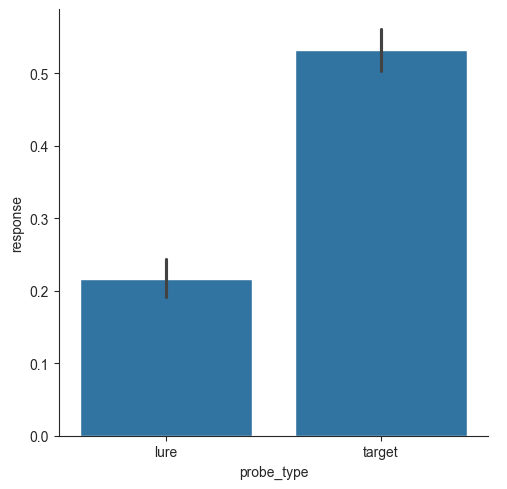

In [13]:
sns.catplot(data=perf, x="probe_type", y="response", kind="bar");

To make this plot, we indicated that the x-axis should be based on the `probe_type` column and the y-axis should be based on the `response` column. The `barplot` function automatically split our data into "lure" and "target" bins and calculated the mean response. 

It also calculated 95% confidence intervals using a bootstrap method, which estimate how much the mean would vary if we repeated the same experiment and collected the same measures over and over. To create a bootstrap confidence interval, Seaborn takes the distribution of observations and randomly samples from it with replacement to make a new set of observations. Then it calculates the mean of this *bootstrap* distribution. It does this 1000 times and then plots a line showing the middle 95% of means from the bootstrap.

We can make exactly the same plot using a horizontal bar plot, if we exchange the x-axis and y-axis inputs. This is sometimes useful if the labels of the different categories are long, as long labels are harder to fit on the x-axis.

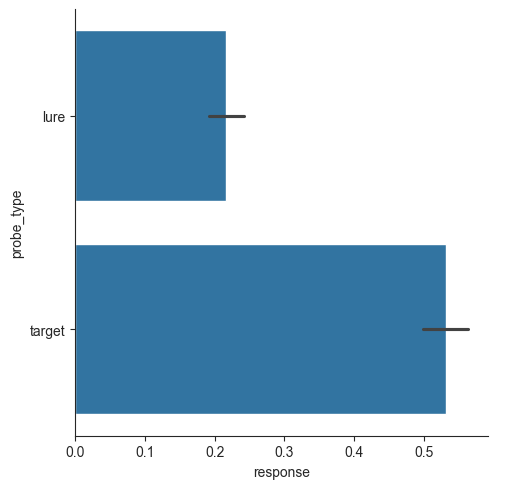

In [14]:
sns.catplot(data=perf, x="response", y="probe_type", kind="bar");

Bar plots just show the means and uncertainty in the means. We can also make *swarm plots* that show the individual points in the different distributions. This is more complicated to look at, but it gives a more realistic sense of the data.

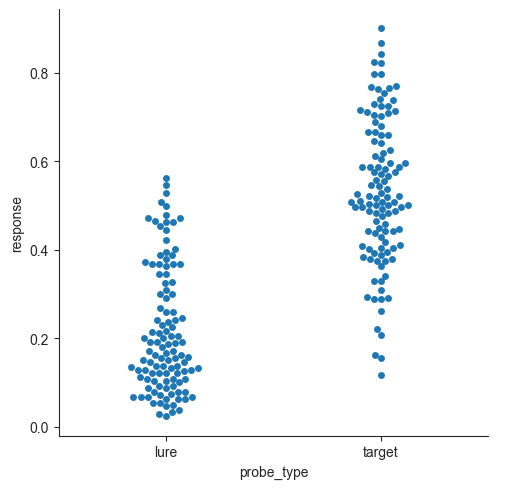

In [15]:
sns.catplot(data=perf, x="probe_type", y="response", kind="swarm");

A similar type of plot is called a *strip plot*. Instead of plotting points that don't overlap, points are plotted within a strip with some jitter.

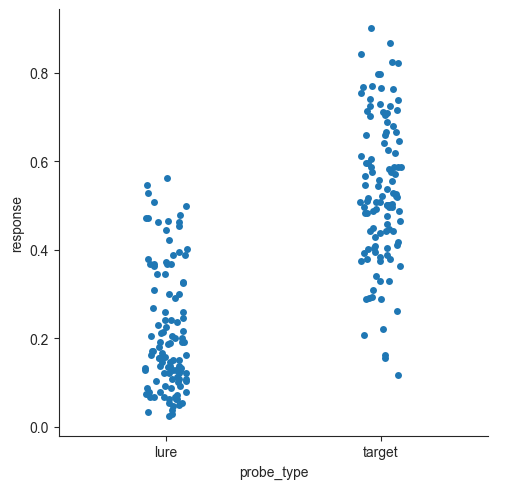

In [16]:
sns.catplot(data=perf, x="probe_type", y="response", kind="strip");

Strip plots sometimes work better than swarm plots when there are a lot of observations that bunch up and make the swarm plot too wide for the plot.

Another common type of plot is called a *box plot*. It shows more detail than a bar plot, but does not show individual points like a swarm plot. The box shows the middle *quartiles* of the distribution. The quartiles include the 25th, 50th, and 75th percentiles. Box plots separate out points that are near the central tendency of the distribution from *outliers*. 

Outliers are determined based on the interquartile range (IQR), which is the difference between the 75th and 25th percentiles.

Points are considered outliers if they are more than 1.5 IQRs away from the nearest quartile. The whiskers at the top and bottom show the range of points that are *not* outliers. Any outliers are plotted as individual points.

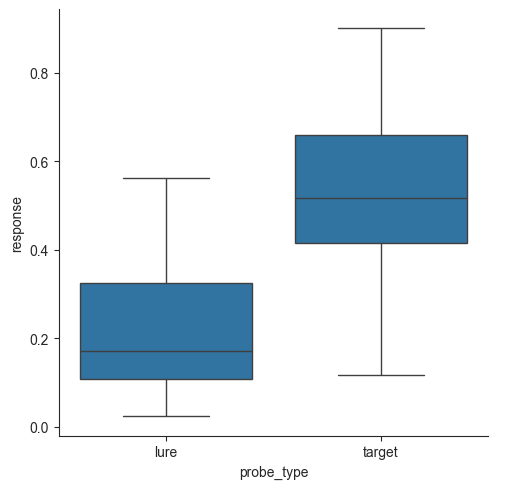

In [17]:
g = sns.catplot(data=perf, x="probe_type", y="response", kind="box")

Swarm and strip plots give a better sense of the underlying data, but box plots make the range and median of the data easy to see.

Sometimes we care about multiple dimensions of the data. For example, we can split the response times up by the probe type and type of response ("old" or "new"). First, we'll get the data in shape. This example uses a *conditional* expression to relabel the responses of 0 and 1 as "new" and "old", respectively.

In [18]:
conditions = (
    data.with_columns(
        response=pl.when(pl.col("response") == 0).then(pl.lit("new")).otherwise(pl.lit("old"))
    )
    .group_by("subj", "probe_type", "response")
    .agg(pl.col("RT").mean())
    .sort("subj", "probe_type", "response")
)
conditions.head(4)

subj,probe_type,response,RT
i64,str,str,f64
101,"""lure""","""new""",1.913257
101,"""lure""","""old""",2.0125
101,"""target""","""new""",1.850839
101,"""target""","""old""",1.584497


Now that we have our bins defined, we can use a bar plot to visualize how mean response time varies depending on probe type and response. We'll represent response using the *hue* parameter.

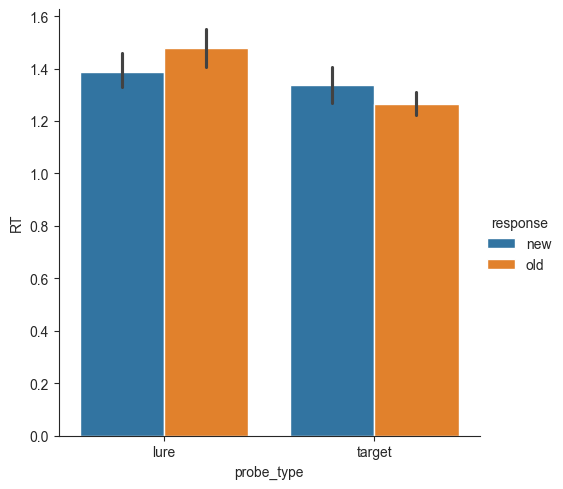

In [19]:
sns.catplot(data=conditions, x="probe_type", y="RT", hue="response", kind="bar");

From this plot, we can see that correct responses ("new" for lures, and "old" for targets) tend to be faster. Responses to targets also tend to be faster overall.

See the Seaborn documentation for more information about [visualizing categorical data](https://seaborn.pydata.org/tutorial/categorical.html).

### Exercise: categorical plots

First, let's set up DataFrames for plotting. We'll use data from the Morton et al. (2013) free-recall study. Participants studied lists of celebrities, locations, and objects, and then were asked to recall the items in any order. Lists were either pure (all the same category) or mixed (items from each of the three categories).

In [20]:
fr = (
    pl.read_csv(datasets.get_dataset_file("Morton2013"), null_values="n/a")
    .filter(pl.col("study"))
)

First, we'll get the mean fraction of items recalled for each subject and list type.

In [21]:
recall_lt = (
    fr.group_by("subject", "list_type")
    .agg(pl.col("recall").mean())
    .sort("subject", "list_type")
)
recall_lt.head(2)

subject,list_type,recall
i64,str,f64
1,"""mixed""",0.476389
1,"""pure""",0.564815


Next, we'll split things up a little more, to get the mean fraction of items recalled for each subject, list type, and category.

In [22]:
recall_lt_cat = (
    fr.group_by("subject", "list_type", "category")
    .agg(pl.col("recall").mean())
    .sort("subject", "list_type", "category")
)
recall_lt_cat.head(6)

subject,list_type,category,recall
i64,str,str,f64
1,"""mixed""","""cel""",0.5875
1,"""mixed""","""loc""",0.433333
1,"""mixed""","""obj""",0.408333
1,"""pure""","""cel""",0.625
1,"""pure""","""loc""",0.5625
1,"""pure""","""obj""",0.506944


Use the `recall_lt` DataFrame to make a bar plot of showing mean recall for each list type.

Use the `recall_lt` DataFrame to make a swarm plot showing mean recall for each list type.

Use the `recall_lt_cat` DataFRame to make a bar plot showing mean recall for each list type, split by category.

In [23]:
# your code here

## Relational plots

Relational plots are used to show a relationship between two variables. For example, you might be interested in whether two measures are correlated with one another, or how some variable changes over time.

Say we are interested in the relationship between response time on target and lure trials, across participants. Is speed on these different trials related? First, let's display the DataFrame to remind ourselves how the data are arranged.

In [24]:
perf.head()

subj,probe_type,response,RT
i64,str,f64,f64
101,"""lure""",0.108333,1.924008
101,"""target""",0.76569,1.646904
102,"""lure""",0.241667,1.088396
102,"""target""",0.2875,1.061537
103,"""lure""",0.091667,1.415992


We can use a pivot table to set up our variables of interest in different columns. Here, we'll make columns from the `probe_type` column and get the values from the `RT` column.

In [25]:
response_time = perf.pivot("probe_type", index="subj", values="RT")
response_time.head()

subj,lure,target
i64,f64,f64
101,1.924008,1.646904
102,1.088396,1.061537
103,1.415992,1.152863
104,1.102379,1.096696
105,1.331477,1.186833


We can use `relplot` to visualize this relationship. By default, `relplot` will make a scatterplot, with one point for each pair of observations.

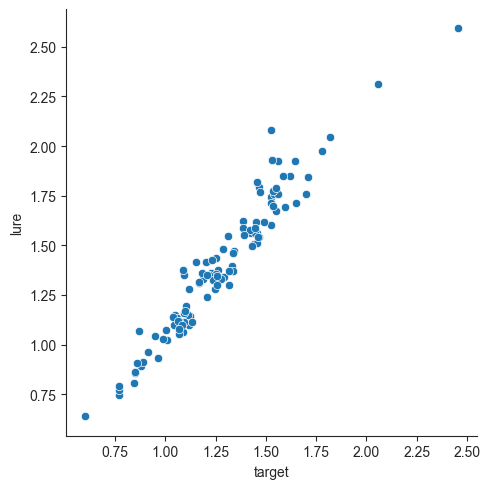

In [26]:
sns.relplot(data=response_time, x="target", y="lure");

Sometimes, we have an independent variable that varies across multiple numeric values, and a dependent variable that may be related to that independent variable. We can visualize this type of relationship using a *line plot*.

In the Osth & Fox (2019) dataset, the main question of interest was whether lag between rearranged pairs would affect the false-alarm rate. Let's get the mean probability of responding "old" for each subject and lag.

In [27]:
lures = (
    data.filter(pl.col("probe_type") == "lure")
    .group_by("subj", "lag")
    .agg(
        pl.col("response").mean(),
        pl.col("RT").mean()
    )
    .sort("subj", "lag")
)
lures.head(10)

subj,lag,response,RT
i64,i64,f64,f64
101,1,0.0625,1.723833
101,2,0.1875,1.795167
101,3,0.0625,1.745646
101,4,0.125,2.085083
101,5,0.104167,2.270312
102,1,0.333333,1.06575
102,2,0.208333,1.057562
102,3,0.166667,1.131146
102,4,0.3125,1.052354


Now we can plot false-alarm rate as it varies by lag, to see if there seems to be a relationship there.

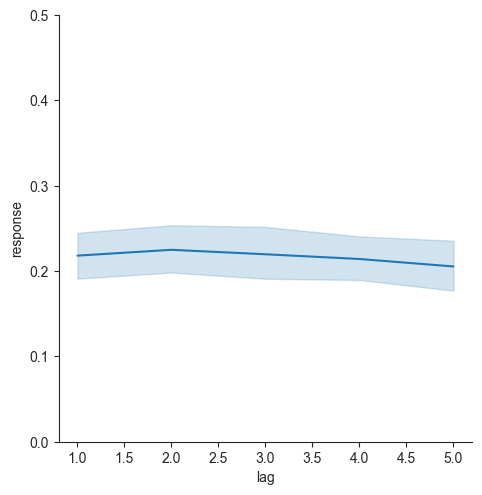

In [28]:
g = sns.relplot(data=lures, x="lag", y="response", kind="line")
g.set(ylim=(0, 0.5));

Here, we've used the FacetGrid object that Seaborn returns to set a property of the figure after making it. We used the `ylim` parameter to indicate that the y-axis should range from 0 (the lowest possible false-alarm rate) to 0.5 (a pretty high false-alarm rate). The plot shows bootstrap confidence intervals, similar to what we had before in our bar plots. Here, there is a confidence *band* that connects the different confidence intervals at each lag.

The plot makes it easy to see that there isn't an obvious relationship between false alarms and lag. There may be a slight trend toward a decrease in false-alarm rate with lag, but it probably isn't statistically reliable.

See the Seaborn documentation for more information about [visualizing statistical relationships](https://seaborn.pydata.org/tutorial/relational.html).

### Exercise: scatter plot

Say that we want to examine whether recall in the mixed and pure lists is correlated across subjects. First, we'll make a pivot table with one column for recall in each of the two list types.

In [29]:
pivot = recall_lt.pivot("list_type", index="subject", values="recall")
pivot.head()

subject,mixed,pure
i64,f64,f64
1,0.476389,0.564815
2,0.55,0.555556
3,0.484722,0.474537
4,0.5375,0.564815
5,0.676389,0.601852


Use data in the `pivot` DataFrame to make a scatterplot showing how recall in the mixed condition relates to recall in the pure condition.

In [30]:
# your code here

### Exercise: line plot

Say that we want to know whether recall depends on the input position of each item in the list. First, we get the mean recall by position for each subject.

In [31]:
spc = (
    fr.group_by("subject", "input")
    .agg(pl.col("recall").mean())
    .sort("subject", "input")
)
spc.head()

subject,input,recall
i64,i64,f64
1,1,0.541667
1,2,0.458333
1,3,0.625
1,4,0.333333
1,5,0.4375


Use the `spc` DataFrame to make a line plot showing how recall varies with input position.

#### Advanced

Seaborn plotting functions like `relplot` return a `FacetGrid` object, which has methods for changing a plot. The `set` method, for example, can be used to change the `ylim` property that determines the range of the y-axis. Add `.set(ylim=(0, 1))` immeediately after your call to `relplot` to set the limits of the y-axis.

In [32]:
# your code here

## Using subplots

The main Seaborn plotting functions (`displot`, `catplot`, and `relplot`) can be used to make multiple plots in one figure, to help visualize different facets of the data.

Let's look again at visualizing response time distributions and how they vary by trial type. Before, we used hue to differentiate response time distributions for different trial types.

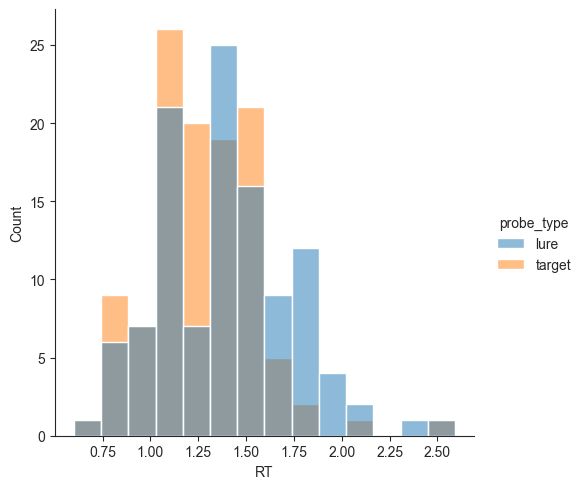

In [33]:
sns.displot(data=perf, x="RT", hue="probe_type", kind="hist");

This can be a little hard to read, given the overlap between the distributions. Another option is to plot lures and targets in different subplots. We can do this using the `col` input instead of `hue`. Each group will be assigned to a different column of the subplot grid.

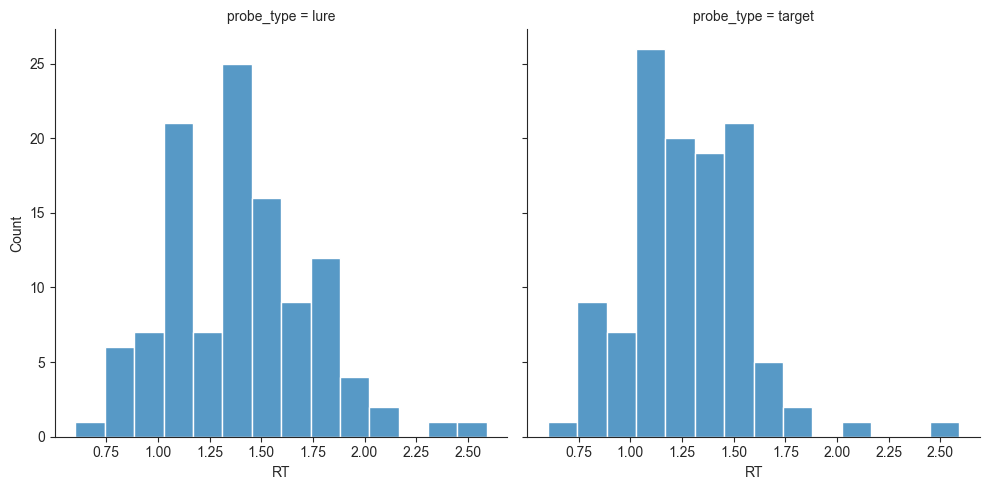

In [34]:
sns.displot(data=perf, x="RT", col="probe_type", kind="hist");

We can also use subplots to split up other kinds of plots. For example, we saw before that we can use `relplot` to visualize how false alarms vary with lure lag.

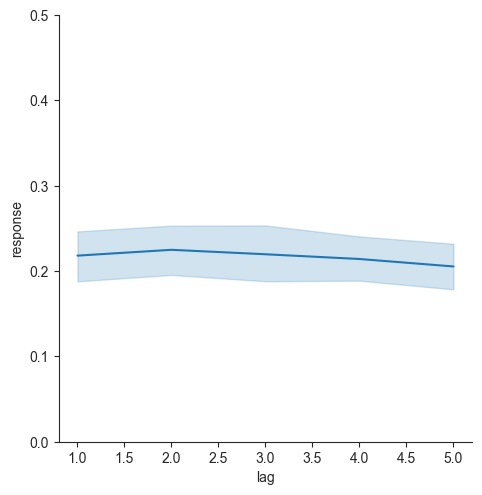

In [35]:
sns.relplot(data=lures, x="lag", y="response", kind="line").set(ylim=(0, 0.5));

We can use the `col` input to visualize this same relationship for individual subjects. We can use the `col_wrap` input to make a grid; it will "wrap" after the fourth column and move to the next row. We'll plot the first 12 subjects, to see how the relationship looks for different people.

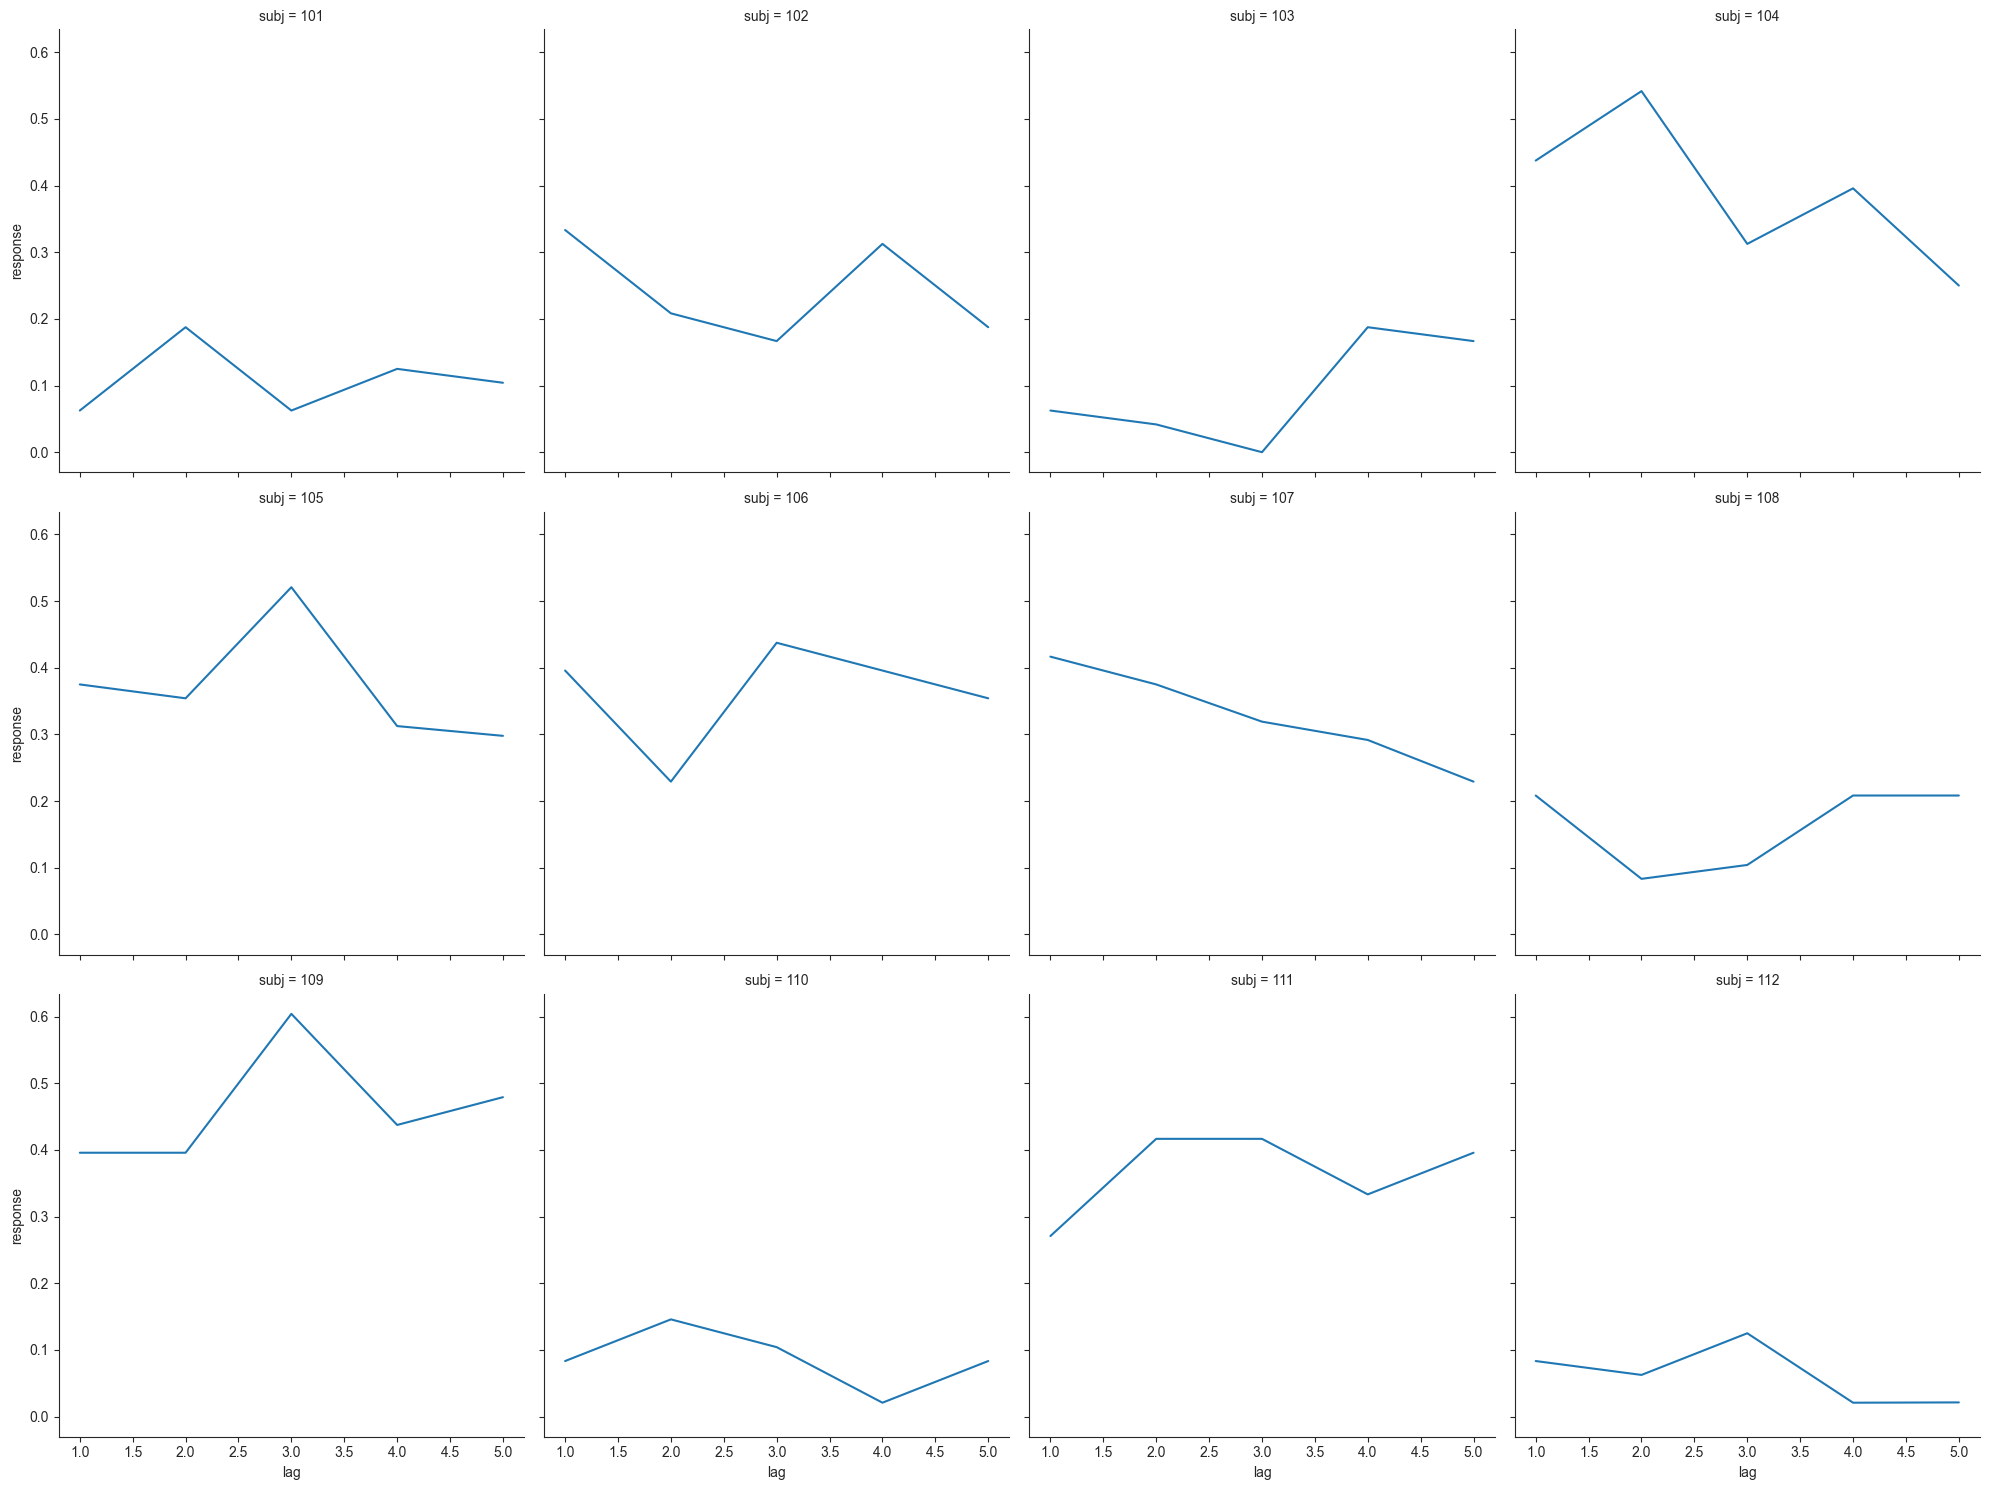

In [36]:
subj12 = lures["subj"].unique()[:12].to_list()
lure12 = lures.filter(pl.col("subj").is_in(subj12))
sns.relplot(data=lure12, x="lag", y="response", col="subj", col_wrap=4, kind="line");

We can use the `col` input to split up a plot by any group that we have a column for in the DataFrame.

### Exercise: using subplots

Say we want to examine how recall in the Morton et al. (2013) dataset varies with input position and category. First, we'll calculate mean recall by subject, input position, and category.

In [37]:
spc_cat = (
    fr.group_by("subject", "input", "category")
    .agg(pl.col("recall").mean())
    .sort("subject", "input", "category")
)
spc_cat.head()

subject,input,category,recall
i64,i64,str,f64
1,1,"""cel""",0.526316
1,1,"""loc""",0.307692
1,1,"""obj""",0.75
1,2,"""cel""",0.526316
1,2,"""loc""",0.384615


Use the `spc_cat` DataFrame to make three line plots showing how recall varies with output position, split up by category (one plot in each of three columns).

Compare this plot to a single line plot that labels each category using a different color.

In [38]:
# your code here

## Choosing color palettes

When color is used as a dimension of a plot, the choice of color is very important. Color differences should be constant over the whole scale, easy to understand, and viewable by people with color blindness.

Seaborn comes with a collection of color palettes that are useful for different purposes. We can visualize these palettes separately in Jupyter.

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

[(0.275191, 0.194905, 0.496005),
 (0.212395, 0.359683, 0.55171),
 (0.153364, 0.497, 0.557724),
 (0.122312, 0.633153, 0.530398),
 (0.288921, 0.758394, 0.428426),
 (0.626579, 0.854645, 0.223353)]

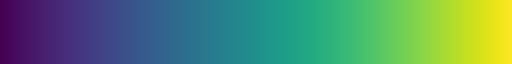

In [39]:
display(sns.color_palette())  # the default palette
display(sns.color_palette("viridis"))  # a sequential scale with 6 bins
display(sns.color_palette("viridis", as_cmap=True))  # a continuous sequential scale

A *qualitative* palette maps a small number of distinct values, such as categories, to distinct colors.

A *sequential* palette maps an ordered variable to a color scale. Sequential maps may either have a small set of bins, or may be continuous.

We will use the Morton et al. (2013) study of free recall for these examples.

## Qualitative color palettes

Qualitative color palettes are best to use when there is no inherent ordering of categories. Seaborn tries to identify when this is the case (for example, when conditions are divided up based on a column with strings) and select a palette that maximizes contrast between categories.

For example, say we want to compare recall based on category and list type. We first calculate the mean recall for each combination of conditions.

In [40]:
cat_lt = (
    fr.group_by("subject", "category", "list_type")
    .agg(pl.col("recall").mean())
)

We can then plot the mean recall using a bar plot, with different hues for the different categories. The optional `palette` input determines the set of hues that will be used.

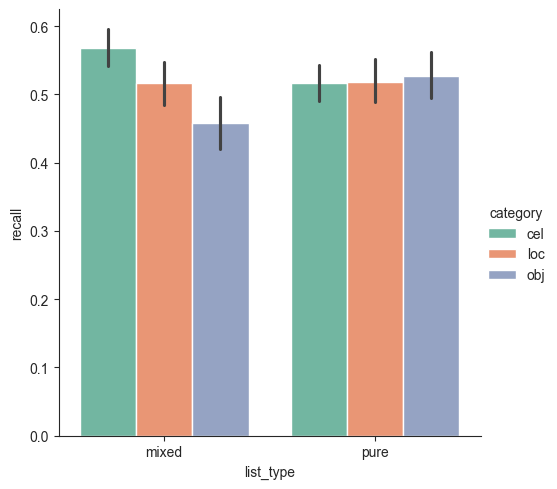

In [41]:
sns.catplot(data=cat_lt, x="list_type", y="recall", hue="category", kind="bar", palette="Set2");

Seaborn comes with a number of good qualitative palettes, which vary in how bright or muted they are and how colorblind-friendly they are. It's a good idea to avoid having red and green in the same set of colors, to make your plots easier for colorblind people to read. See the [Seaborn qualitative palette tutorial](https://seaborn.pydata.org/tutorial/color_palettes.html#qualitative-color-palettes) for more information.

In [42]:
display(sns.color_palette())
display(sns.color_palette("Set1"))
display(sns.color_palette("Set2"))
display(sns.color_palette("colorblind"))

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6)]

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

## Sequential color palettes

Sequential color palettes are designed for visualization of variables that vary on a range. For example, recall accuracy varies from 0 to 1. Ideally, we want the color scale to vary smoothly, to match the underlying data. Seaborn includes sequential palettes that are carefully designed based on what we know about color perception.

Sequential color palettes are often used to present data in images. For example, say we want to see how recall varies by the serial position of items in a list, and we want to see this for each subject in a study. We can visualize this using a *heatmap*.

First, we get a two-dimensional array with the data we want to plot.

In [43]:
sp = (
    fr.filter(pl.col("study"))
    .group_by("subject", "input")
    .agg(pl.col("recall").mean())
)
n = sp.shape[0]
M = 24
N = int(n / M)
mat = sp.sort("subject", "input")["recall"].to_numpy().reshape((N, M))

Next, we'll convert the matrix into a Pandas DataFrame. Unlike Polars DataFrames, Pandas DataFrames include both column labels and row labels, which are called an *index*. This lets us set labels for both the x and y dimensions automatically when using Seaborn to visualize it.

In [44]:
import pandas as pd
x_tick_labels = [str(i) for i in range (1, M + 1)]
y_tick_labels = fr["subject"].unique()
df = pd.DataFrame(mat, columns=x_tick_labels, index=y_tick_labels)

Now that the data matrix is prepared, we can use Seaborn's `heatmap` function to plot it. We'll add labels for the x-axis and y-axis.

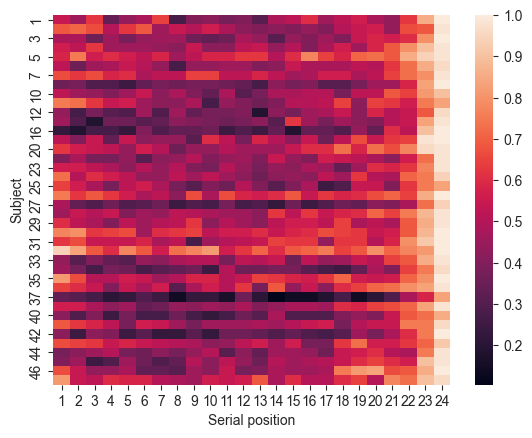

In [45]:
ax = sns.heatmap(df)
ax.set_ylabel("Subject")
ax.set_xlabel("Serial position");

The heatmap includes an x-axis (serial position), a y-axis (subject), and a color scale (recall probability). This lets us see how three different variables relate to one another. The color bar on the right indicates the relationship between color in the plot and the dimension we are plotting.

Seaborn includes a number of excellent sequential color palettes, which are designed to vary in a *perceptually uniform* way. If we use one of these scales, then changes in the variable being plotted will correspond to a similar visual change in the color. See the [Seaborn sequential palettes tutorial](https://seaborn.pydata.org/tutorial/color_palettes.html#sequential-color-palettes) for more information.

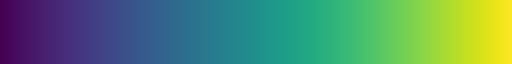

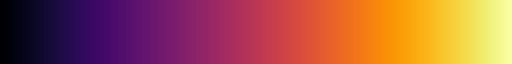

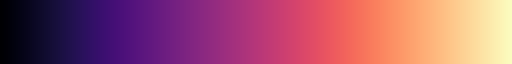

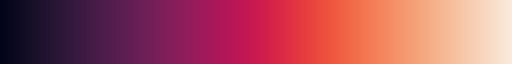

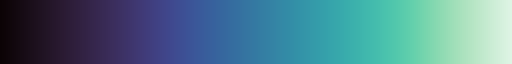

In [46]:
display(sns.color_palette("viridis", as_cmap=True))
display(sns.color_palette("inferno", as_cmap=True))
display(sns.color_palette("magma", as_cmap=True))
display(sns.color_palette("rocket", as_cmap=True))
display(sns.color_palette("mako", as_cmap=True))

The choice of palette, also sometimes called a *color map*, is very important, because it affects the appearance of our data.

Say that we have some matrix that we want to visualize. We might consider three common palettes:

gray
: A simple scale for mapping values to colors. Brighter areas correspond to greater values.

viridis
: A recently developed color map that is designed to have a wide range of colors that is perceptually uniform and easy to interpret. Brighter, more yellow areas correspond to greater values.

jet
: A "rainbow" color map that uses most colors that humans can perceive. Warmer colors correspond to greater values.

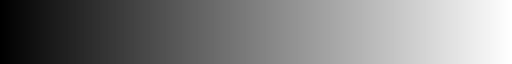

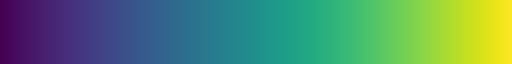

In [47]:
display(sns.color_palette("gray", as_cmap=True))
display(sns.color_palette("viridis", as_cmap=True))
# display(sns.color_palette("jet", as_cmap=True))  # throws an error because the author of Seaborn hates jet

When creating a heatmap, we can indicate the colormap to use using the `cmap` input. In this example, we will use `matplotlib` to set up a figure with three *subplots* so we can visualize different heatmaps side-by-side.

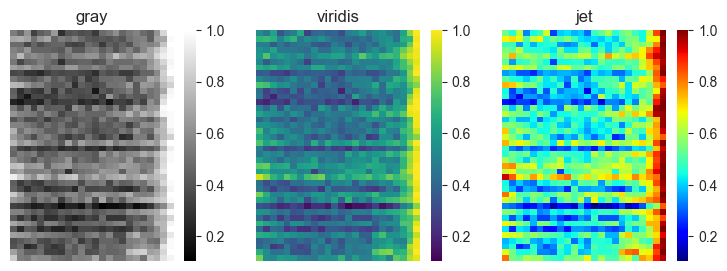

In [48]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
cmaps = ["gray", "viridis", "jet"]
for i, cmap in enumerate(cmaps):
    sns.heatmap(df, ax=ax[i], cmap=cmap)
    ax[i].axis("off")
    ax[i].set_title(cmap)

Researchers often choose a rainbow color map like `jet` because it has been used historically in scientific publications, and shows a lot of detail due to its wide variation in color. However, it has serious problems that cause issues with using it in scientific research. It is perceptually not uniform, with the appearance of bands in the color scale. Values mapped near to yellow and cyan appear to vary more than values that are mapped near red and blue. The order of colors is also not obvious; the reader needs to carefully consult the color bar to know which colors correspond to greater values.

It can be hard to appreciate differences between color maps when looking at an unfamiliar data matrix. In contrast, using them to visualize a photo makes the advantages and disadvantages of different color maps obvious. Let's look at a black-and-white photograph of the psychology researcher Hermann Ebbinghaus, who ran himself through rigorous tests of his own memory.

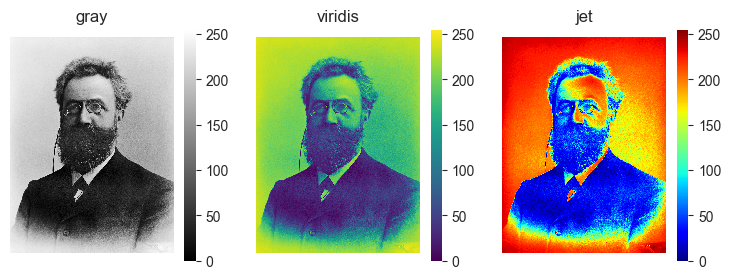

In [49]:
from PIL import Image
image = Image.open("Ebbinghaus.jpg")

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
cmaps = ["gray", "viridis", "jet"]
for i, cmap in enumerate(cmaps):
    sns.heatmap(image, ax=ax[i], cmap=cmap)
    ax[i].axis("equal")
    ax[i].axis("off")
    ax[i].set_title(cmap)

The `viridis` color map looks similar to the original photo, but uses variation in color to make it easier to see highlights and shadows. The `jet` color map distorts the data, making the image appear to have color "bands" that are not in the actual photo. It also makes it hard to tell which parts of the image are supposed to be light, and which are supposed to be dark.

To avoid these problems, use one of Seaborn's [perceptually uniform palettes](https://seaborn.pydata.org/tutorial/color_palettes.html#perceptually-uniform-palettes).

## Summary

### Plot types

Seaborn makes it relatively easy to make common types of plots.

*Distributional* plots can be used to visualize variation in some measurement.

*Categorical* plots can be used to visualize how a measurement differs between experimental conditions.

*Relational* plots can be used to visualize relationships between variables.


### Color Palettes

Color palettes built into Seaborn help to visualize variables.

*Qualitative* palettes are designed for representing unordered categories.

*Sequential* palettes are designed for representing values that vary over some range.